## 8.2 합성곱 신경망 실전 활용 예제

개와 고양이 사진을 대상으로 이항분류를 구현하는 모델을 합성곱 신경으로 구현한다.
실전 상황을 묘사하기 위해 5천 개의 이미지로 이루어진 작은 데이터셋을 훈련, 검증, 테스트 용도로 사용한다. 
실제로 훈련셋의 크기가 수 백에서 수 천인 경우가 매우 일반적으로 발생한다.

모델 훈련 과정은 다음과 같다.

- 직접 합성곱 신경망 모델 구현 및 훈련
    - 합성곱 신경망은 작은 크기의 데이터셋으로도 적절한 성능을 얻을 수 있음.
    - 하지만 데이터 증식을 적용하거나 기존에 잘 훈련된 모델을 재활용하여 보다 높은 성능의 모델 구현 가능.
- 데이터 증식 기법 추가
    - 작은 데이터셋의 크기를 늘리는 기법
- 기존에 알려진 모델 재활용
    - 특성 추출 기법
    - 파인 튜닝(fine-tunig)

### 데이터 다운로드

훈련에 필요한 데이터를 다운로드한다.
하지만 이어지는 데이터 다운로드 관련 코드의 실행은 주의를 기울여야 한다.

- 캐글(kaggle) 계정을 갖고 있어야 하며, 로그인된 상태에서 아래 두 과정을 먼저 해결해야 한다.
- 캐글에 로그인한 후 "Account" 페이지의 계정 설정 창에 있는 "API" 항목에서
    "Create New API Token"을 생성하여 다운로드한다.
- [캐글: Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/rules)를
    방문해서 "I Understand and Accept" 버튼을 클릭해야 한다.

다음 네 개의 이어지는 코드셀은 구글 코랩에서만 실행해야 한다.
현재 구글 코랩을 사용하고 있는지 여부는 아래와 같이 확인할 수 있다.

```python
if 'google.colab' in str(get_ipython()):
    print('구글 코랩 사용중!')
else:
    print('구글 코랩 환경 아님!')
```

개인 PC에서 실행하고자 할 경우 다음 사항들을 고려해야 한다.

- `kaggle.json` 파일을 아래 둘째 코드셀에서 
    지정한 경로와 동일한 곳에 저장한 후에 3 단계부터 실행하면 된다.
    단, `kaggle` API가 설치되어 있어야 한다. 
    아니면 주피터 노트북에서 아래 명령문을 실행한다.

    ```python
    !pip install kaggle
    ```

- `kaggle` API를 굳이 설치하지 않으려면 
    [캐글: Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)에서
    `train.zip` 파일을 다운로드하여 현재 주피터 노트북이 실행되는 디렉토리에 저장한 후에
    4 단계부터 실행하면 된다.

In [ ]:
# !pip install kaggle

- 다운로드 1단계

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('구글 코랩 사용중!')
    from google.colab import files
    files.upload()
else:
    print('구글 코랩 환경 아님!')

구글 코랩 사용중!


Saving kaggle.json to kaggle.json


- 다운로드 2단계

In [ ]:
if 'google.colab' in str(get_ipython()):
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print('구글 코랩 환경 아님!')

- 다운로드 3단계

In [ ]:
# kaggle api를 업그레이드해야 할 수도 있음.
# !pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c dogs-vs-cats

100% 271M/271M [00:01<00:00, 155MB/s]
100% 271M/271M [00:01<00:00, 150MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 84.5MB/s]
 99% 538M/543M [00:03<00:00, 172MB/s]
100% 543M/543M [00:03<00:00, 161MB/s]


- 다운로드 4단계

In [ ]:
try:
    !unzip -qq train.zip
except:
    !unzip -qq dogs-vs-cats.zip  # kaggle API 버전에 따라 다운로드 파일 다름.
    !unzip -qq train.zip

다운로드된 데이터셋 전체는 총 25,000장의 강아지와 고양이 사진으로 구성되었으며 570MB 정도로 꽤 크다.
강아지와 고양이 각각 12,500 장씩 포함되어 있으며,
사진들의 크기가 다음과 같이 일정하지 않다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dog_and_cat_samples.png" style="width:700px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

**훈련셋, 검증셋, 테스트셋 준비**

25,000 장의 사진 중에서 총 5,000 장의 사진만 사용해서 합성곱 신경을 훈련시키려 한다.

- 훈련셋: 강아지와 고양이 각각 1,000 장
- 검증셋: 강아지와 고양이 각각 500 장
- 테스트셋: 강아지와 고양이 각각 1,000 장

아래 코드는 앞서 지정한 대로 총 5,000 장의 사진으로 이루어진 데이터셋을
추출해서 각각의 디렉토리에 저장한다.
디렉토리의 구성은 다음과 같다.

```
cats_vs_dogs_small/
...train/
......cat/
......dog/
...validation/
......cat/
......dog/
...test/
......cat/
......dog/
```

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### 모델 구성

convnet(합성곱 신경망) 모델은 앞서 설명한대로 `Conv2D`와 `MaxPooling2D` 레이어를
연속에서 쌓는 방식을 사용한다.
다만, 보다 복잡한 모델 구성을 위해 보다 높은 층 스택을 쌓는다.

- 입력층: 입력 샘플의 모양을 `(180, 180, 3)`으로 지정. 픽셀 크기는 임의로 지정함.
    사진의 크기가 제 각각이기에 먼저 지정된 크기의 텐서로 변환을 해주는 전처리 과정이 필요함.
- 출력층: 이항분류 모델이기에 한 개의 유닛과 시그모이드 활성화 함수 사용.
- `Rescaling(1./255)` 층: 0에서 255 사이의 값을 0에서 1 사이의 값으로 변환하는 용도로 사용

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# 입력층
inputs = keras.Input(shape=(180, 180, 3))

# 은닉층
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

강아지와 고양이의 비율이 동일하기에 정확도를 평가지표로 사용한다.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### 데이터 전처리

샘플 사진의 크기가 제 각각이기에 모델의 입력값으로 지정된 크기인 `(180, 180, 3)` 모양의 
텐서로 변환을 해주어야 한다.
케라스의 `image_dataset_from_directory()` 함수를 이용하면 변환 뿐만 아니라
지정된 배치 크기의 배치로 구성된 훈련셋, 검증셋, 테스트셋을 쉽게 생성할 수 있다.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


생성된 `train_dataset`, `validation_dataset`, `test_dataset`은 모두
`BatchDataset` 클래스의 객체이다.

**생성된 데이터셋 항목 확인**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**참고**

다음 네 개의 코드셀은 `BatchDataet`의 부모 클래스인 
`Dataset` 자료형의 간단한 기능과 활용법을 보여준다.

- 참고 1: 설명을 위해 넘파이 어레이를 이용하여 `Dataset` 객체 생성
    - `(1000, 16)` 모양의 넘파이 어레이 활용

In [ ]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

- 참고 2: 이터러블 자료형임.

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


- 참고 3: `batch()` 메서드 활용

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


- 참고 4: `map()` 메서드 활용 예제: 모양 변환

In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**모델 훈련**

- `ModelCheckpoint`: `"val_loss"` 기준으로 최고 성능 모델 저장 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 39s 119ms/step - loss: 0.8227 - accuracy: 0.5095 - val_loss: 0.6927 - val_accuracy: 0.5020
Epoch 2/30
63/63 [==============================] - 7s 105ms/step - loss: 0.6935 - accuracy: 0.5480 - val_loss: 0.8215 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 7s 103ms/step - loss: 0.6718 - accuracy: 0.6070 - val_loss: 0.6257 - val_accuracy: 0.6470
Epoch 4/30
63/63 [==============================] - 7s 104ms/step - loss: 0.6333 - accuracy: 0.6655 - val_loss: 0.5968 - val_accuracy: 0.6790
Epoch 5/30
63/63 [==============================] - 7s 104ms/step - loss: 0.5838 - accuracy: 0.6960 - val_loss: 0.6059 - val_accuracy: 0.6460
Epoch 6/30
63/63 [==============================] - 7s 104ms/step - loss: 0.5437 - accuracy: 0.7230 - val_loss: 0.5600 - val_accuracy: 0.7050
Epoch 7/30
63/63 [==============================] - 7s 105ms/step - loss: 0.4968 - accuracy: 0.7530 - val_loss: 0.8214 - val_accuracy: 0.6510
Epoch

**훈련 과정 확인**

- 과대 적합이 10번 정도의 에포크 이후에 빠르게 발생

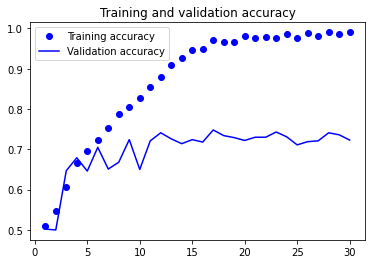

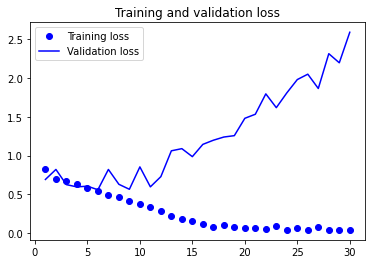

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**모델 평가**

- 훈련된 최고 성능의 모델에 대한 테스트 결과는 69~70% 정도이다.
- 과대적합이 매우 빠르게 발생한 이유는 훈련셋의 크기가 2,000 정도로 너무 작다.

In [ ]:
# 최선 모델 적재
test_model = keras.models.load_model("convnet_from_scratch.keras")

# 테스트 결과
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 48ms/step - loss: 0.5920 - accuracy: 0.7005
Test accuracy: 0.701


### 데이터 증식

데이터 증식 기법을 사용하여 훈련셋의 크기를 키우면,
과대 적합이 보다 늦게 발생하고 따라서 보다 좋은 성능의 모델을 얻게 된다.
케라스의 데이터 증식 층을 이용하여 쉽게 데이터 증식을 구현할 수 있다.
아래 코드는 Sequential 모델을 이용하여 간단하게 데이터 증식 층을 구현한다.

- `RandomFlip()`: 사진을 50%의 확률로 지정된 방향으로 회전. 
- `RandomRotation()`: 사진을 지정된 범위 안에서 임의로 좌우로 회전
- `RandomZoom()`: 사진을 지정된 범위 안에서 임의로 확대 및 축소

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

훈련셋의 첫째 이미지를 대상으로 9번 데이터 증식 기법을 적용한 결과를 
아래와 같이 확인할 수 있다.

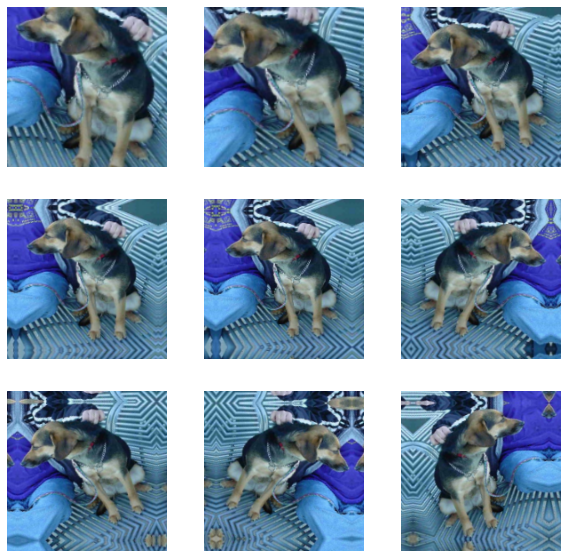

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

모델 구성을 다시 한다. 

- 데이터 증식 포함
- 출력층 바로 이전에 드롭아웃(Dropout) 추가. 과대적합 방지용.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

모델 훈련은 동일하다. 다만 에포크 수를 100으로 늘린다.
이유는 과대적합이 보다 늦게 발생할 것이기 때문이다.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 112ms/step - loss: 0.7678 - accuracy: 0.5090 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 7s 109ms/step - loss: 0.6952 - accuracy: 0.5075 - val_loss: 0.6922 - val_accuracy: 0.5160
Epoch 3/100
63/63 [==============================] - 7s 108ms/step - loss: 0.6938 - accuracy: 0.5505 - val_loss: 0.6805 - val_accuracy: 0.5520
Epoch 4/100
63/63 [==============================] - 7s 109ms/step - loss: 0.6974 - accuracy: 0.6125 - val_loss: 0.6780 - val_accuracy: 0.5650
Epoch 5/100
63/63 [==============================] - 7s 109ms/step - loss: 0.6594 - accuracy: 0.6150 - val_loss: 0.7153 - val_accuracy: 0.5370
Epoch 6/100
63/63 [==============================] - 7s 109ms/step - loss: 0.6456 - accuracy: 0.6255 - val_loss: 0.6334 - val_accuracy: 0.6500
Epoch 7/100
63/63 [==============================] - 7s 108ms/step - loss: 0.6232 - accuracy: 0.6655 - val_loss: 0.7212 - val_accuracy: 0.5810

과대 적합이 보다 늦게 발생함을 확인할 수 있다.

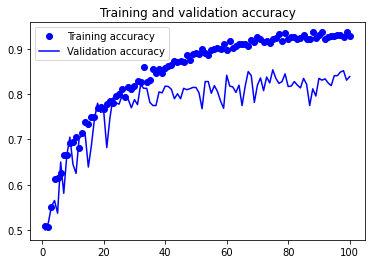

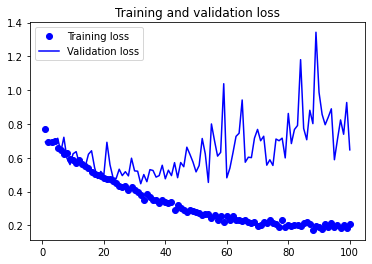

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# 정확도 그래프
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# 손실 그래프
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

테스트셋에 대한 성능은 83% 정도로 올라갔다.

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 47ms/step - loss: 0.4594 - accuracy: 0.8155
Test accuracy: 0.816


`Conv2D`와 `MaxPooling2D` 층을 더 쌓거나 층에 사용된 필터수를 늘리는 방식으로
모델의 성능을 90% 정도까지 끌어올릴 수는 있지만 그 이상은 어려울 것이다.

**참고**

`convnet_from_scratch_with_augmentation.keras` 모델을 
나중에 재활용하고자 한다. 이를 위해 구글 코랩을 사용하는 경우 모델을 저장해 두어야 한다.

## 8.3 기존에 잘 훈련된 모델 재활용

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 12.0702 - accuracy: 0.9310 - val_loss: 4.3726 - val_accuracy: 0.9700
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.9694 - accuracy: 0.9720 - val_loss: 8.9660 - val_accuracy: 0.9600
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.5155 - accuracy: 0.9875 - val_loss: 4.2537 - val_accuracy: 0.9690
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 2.7655 - accuracy: 0.9880 - val_loss: 4.0915 - val_accuracy: 0.9750
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.8611 - accuracy: 0.9935 - val_loss: 6.9615 - val_accuracy: 0.9640
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 0.8983 - accuracy: 0.9935 - val_loss: 4.0750 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.5476 - accuracy: 0.9935 - val_loss: 3.8334 - val_accuracy: 0.9770
Epoch 8/20
63/63 [

**Plotting the results**

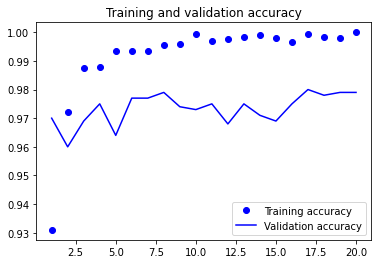

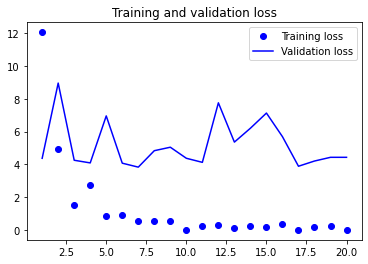

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freeze the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding data augmentation and a densely-connected classifier to the frozen convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 20s 296ms/step - loss: 17.5219 - accuracy: 0.8945 - val_loss: 4.4647 - val_accuracy: 0.9710
Epoch 2/50
63/63 [==============================] - 19s 293ms/step - loss: 8.0237 - accuracy: 0.9410 - val_loss: 4.4186 - val_accuracy: 0.9650
Epoch 3/50
63/63 [==============================] - 19s 294ms/step - loss: 6.8764 - accuracy: 0.9535 - val_loss: 6.6422 - val_accuracy: 0.9590
Epoch 4/50
63/63 [==============================] - 19s 293ms/step - loss: 5.8758 - accuracy: 0.9590 - val_loss: 3.4330 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 19s 294ms/step - loss: 4.6814 - accuracy: 0.9645 - val_loss: 7.8518 - val_accuracy: 0.9610
Epoch 6/50
63/63 [==============================] - 19s 293ms/step - loss: 3.7400 - accuracy: 0.9700 - val_loss: 3.9814 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 19s 294ms/step - loss: 3.3908 - accuracy: 0.9660 - val_loss: 3.4146 - val_accuracy: 0.972

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 187ms/step - loss: 2.2177 - accuracy: 0.9755
Test accuracy: 0.975


### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Freezing all layers until the 4th from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 23s 329ms/step - loss: 0.5251 - accuracy: 0.9860 - val_loss: 2.2520 - val_accuracy: 0.9740
Epoch 2/30
63/63 [==============================] - 21s 323ms/step - loss: 0.2301 - accuracy: 0.9925 - val_loss: 1.5890 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 21s 323ms/step - loss: 0.3149 - accuracy: 0.9920 - val_loss: 1.4698 - val_accuracy: 0.9800
Epoch 4/30
63/63 [==============================] - 21s 323ms/step - loss: 0.2971 - accuracy: 0.9930 - val_loss: 1.6654 - val_accuracy: 0.9800
Epoch 5/30
63/63 [==============================] - 21s 323ms/step - loss: 0.4280 - accuracy: 0.9910 - val_loss: 1.3325 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 21s 323ms/step - loss: 0.2833 - accuracy: 0.9900 - val_loss: 1.6084 - val_accuracy: 0.9760
Epoch 7/30
63/63 [==============================] - 21s 322ms/step - loss: 0.3782 - accuracy: 0.9920 - val_loss: 1.3112 - val_accuracy: 0.9820

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 186ms/step - loss: 1.6727 - accuracy: 0.9755
Test accuracy: 0.975
